# Final Project - Bone Fracture X Rray Identification

## Step 1: Brief description of problem and data

The primary goal of this project is to automate the identification of fractured bones in digital X-ray images. This will be achieved by developing deep learning models capable of accurately classifying whether a given X-ray image contains evidence of a fracture. The dataset used is a comprehensive collection of X-ray images that include both fractured and non-fractured instances, covering various anatomical regions such as the lower limb, upper limb, lumbar, hips, and knees.

https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/data

## Step 2: Exploratory Data Analysis (EDA)

The dataset for this project contains X-ray images categorized into train, test, and validation folders, each containing images labeled as either fractured or non-fractured. The primary task is to classify each image accurately based on the presence or absence of a fracture. Each image is identified by a unique ID, and the truth labels for the images in the train folder are provided in a corresponding labels file.

The dataset is structured to facilitate the training of fully-convolutional models, which are beneficial for ensuring consistent behavior across different image regions. The final task is to predict labels for the images in the test folder.

We will load the necessary libraries and perform exploratory data analysis (EDA) to better understand the data distribution and characteristics before proceeding with model developmen



In [1]:
# Load libraries and data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")


2024-06-27 02:45:40.612846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 02:45:40.612952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 02:45:40.736204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


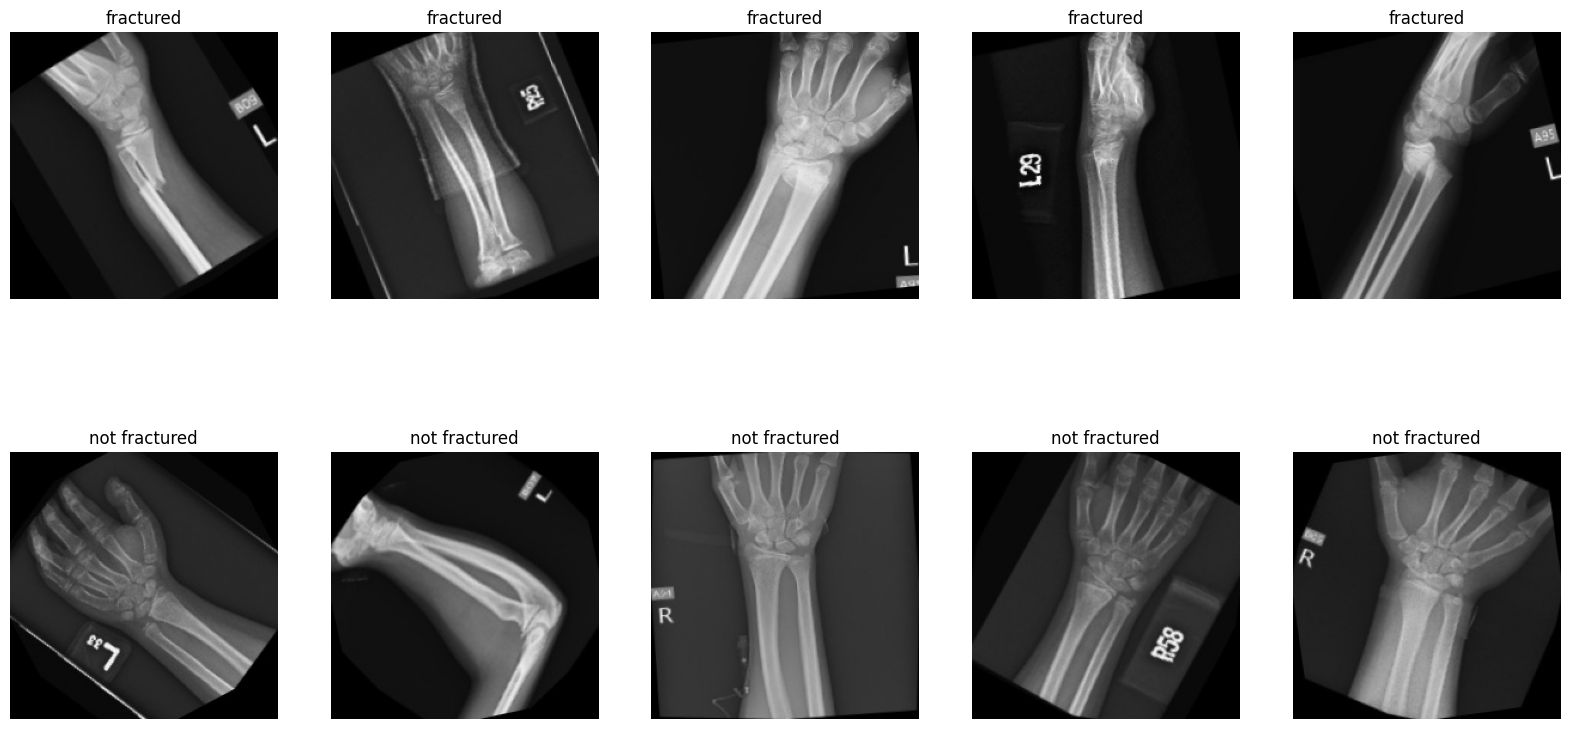

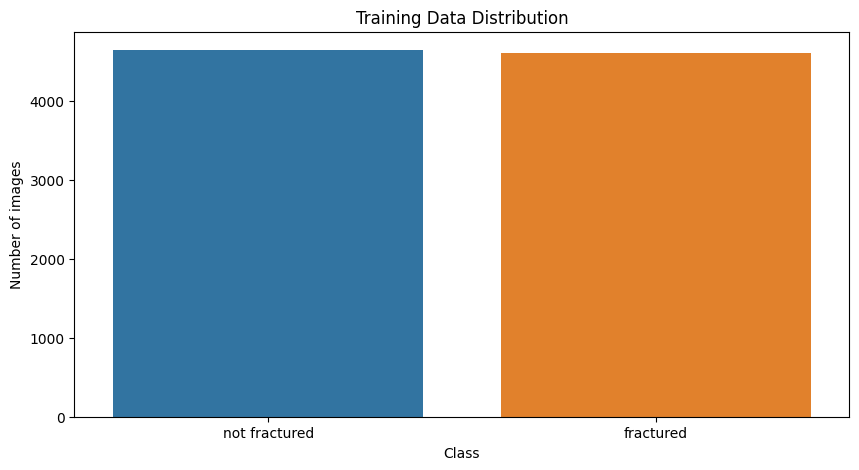

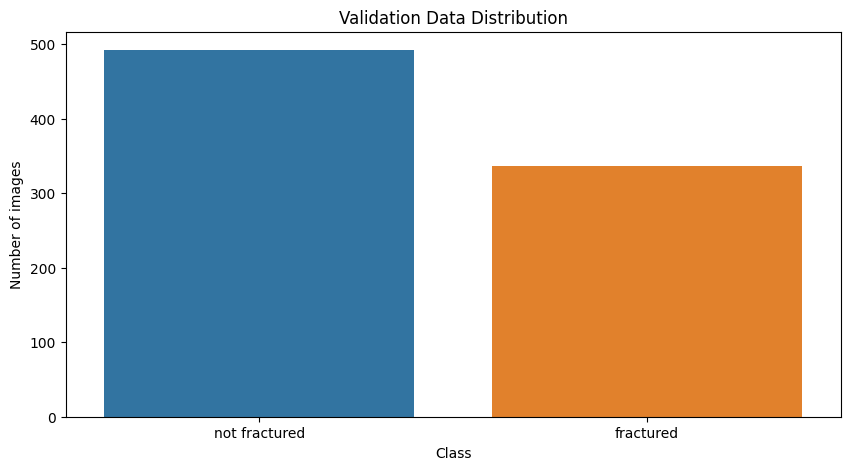

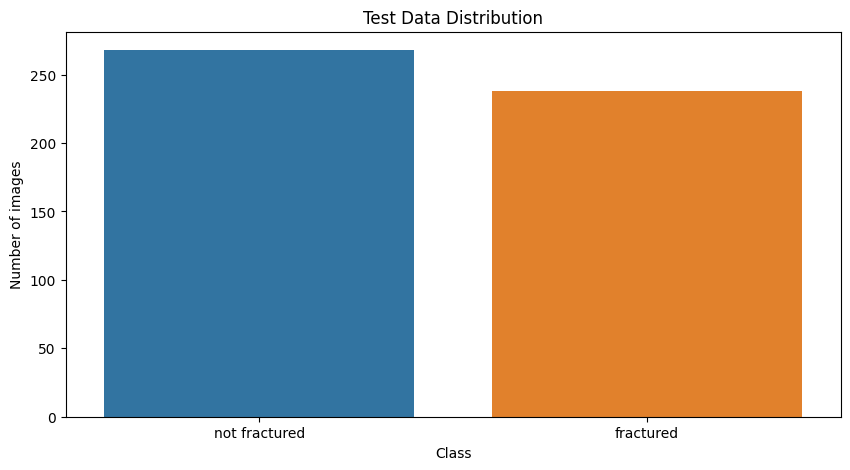

In [2]:

#2 Exploratory Data Analysis
# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Directories for the data
train_dir = '/kaggle/input/bone-fracture-binary-classification/Bone_Fracture_Binary_Classification/train/'
val_dir = '/kaggle/input/bone-fracture-binary-classification/Bone_Fracture_Binary_Classification/val/'
test_dir = '/kaggle/input/bone-fracture-binary-classification/Bone_Fracture_Binary_Classification/test/'

# Function to display sample images for each class
def display_sample_images(generator, class_names, n_samples=5):
    plt.figure(figsize=(20, 10))
    for i, class_name in enumerate(class_names):
        files = os.listdir(os.path.join(train_dir, class_name))
        for j in range(n_samples):
            img = plt.imread(os.path.join(train_dir, class_name, random.choice(files)))
            plt.subplot(len(class_names), n_samples, i*n_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

# Display sample images for each binary class
class_names = ['fractured', 'not fractured']
display_sample_images(train_dir, class_names)

# Function to count the number of images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in train, validation, and test directories
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Display histogram of the distribution of the data
def plot_distribution(counts, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.show()

plot_distribution(train_counts, 'Training Data Distribution')
plot_distribution(val_counts, 'Validation Data Distribution')
plot_distribution(test_counts, 'Test Data Distribution')

After conducting data exploration, it is apparent that distinguishing fractured bone images without specialized knowledge can be challenging. While some images may clearly show fractures, others do not make the injury easily identifiable.

From the data exploration, we also observed that the training dataset is quite balanced, indicating that no additional preprocessing will be required to correct any sampling imbalances. However, we will correct the data to ensure it is properly prepared for model training and evaluation.

To handle the data correctly, we use the ImageDataGenerator from Keras to generate batches of image data with realtime data augmentation. This helps in creating a more robust model by applying random transformations to the training images. Some steps are performed to handle any truncated images in the dataset,to apply several augmentation techniques like rescaling, rotation, width and height shifts, shearing, zooming, and horizontal flipping to prevent overfitting and improve the model's generalization capability. On the validation and test dataset we will re rescale the images to keep the data consistent.


In [3]:

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Prepare data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/bone-fracture-binary-classification/Bone_Fracture_Binary_Classification/train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/bone-fracture-binary-classification/Bone_Fracture_Binary_Classification/val/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/bone-fracture-binary-classification/Bone_Fracture_Binary_Classification/test/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


## Step 3: Model Arquitecture

Model 1: Basic CNN Architecture Model 1 consists of three convolutional layers followed by max-pooling layers, and ends with a fully connected layer. Specifically, it includes Conv2D layers with 32, 64, and 128 filters respectively, each with a 3x3 kernel and ReLU activation. Each convolutional layer is followed by a MaxPooling2D layer with a 2x2 pool size. The network then has a Flatten layer, followed by a Dense layer with 512 units and ReLU activation, a Dropout layer with a rate of 0.5 to prevent overfitting, and a final Dense layer with 1 unit and Sigmoid activation for binary classification. This basic architecture was chosen because it provides a good starting point for image classification tasks, balancing complexity and computational efficiency, and serving as a baseline for comparing more complex architectures.

Model 2: Deeper CNN with More Filters and Additional Convolutional Layers Model 2 extends the architecture of Model 1 by adding an additional convolutional layer and increasing the number of filters. It consists of four Conv2D layers with 32, 64, 128, and 256 filters respectively, each with a 3x3 kernel and ReLU activation, followed by MaxPooling2D layers with a 2x2 pool size. This deeper network is designed to capture more complex features and patterns in the data. The fully connected part of the model includes a Flatten layer, a Dense layer with 512 units and ReLU activation, a Dropout layer with a rate of 0.5, and a final Dense layer with 1 unit and Sigmoid activation. The rationale for this architecture is to improve the model's ability to learn from the data by adding more layers and filters, thereby enhancing feature extraction capabilities.

Model 3: CNN with Different Kernel Sizes and More Dropout Model 3 modifies the architecture further by varying the kernel sizes and increasing the dropout rate to enhance regularization. It includes three Conv2D layers with 64, 128, and 256 filters respectively, where the first two layers use a 5x5 kernel and the third uses a 3x3 kernel, all with ReLU activation. Each convolutional layer is followed by a MaxPooling2D layer with a 2x2 pool size. The model then has a Flatten layer, a Dense layer with 512 units and ReLU activation, a Dropout layer with a rate of 0.6, and a final Dense layer with 1 unit and Sigmoid activation. This architecture was chosen to explore the effects of different kernel sizes on feature extraction and to improve generalization by using a higher dropout rate, aiming to reduce overfitting and improve the model's robustness.:

In [4]:
# 3. Model Architecture

# Define the models

# Model 1: Basic CNN Architecture

model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
    
model1.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])

model1.summary()

# Model 2: Deeper CNN with More Filters and Additional Convolutional Layers

model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
        
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
    ])
    
model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model2.summary()

# Model 3: CNN with Different Kernel Sizes and More Dropout
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(128, (5,5), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.6),  # Increased dropout rate
    Dense(1, activation='sigmoid')
    ])
    
model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
model3.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,263,809 (73.49 MB)

 Trainable params: 19,263,809 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 107, 107, 128)  │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    81,920,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,319,617 (314.02 MB)

 Trainable params: 82,319,617 (314.02 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:

# Train the model
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=20
)

history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=20
)

history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=20
)



Epoch 1/20


2024-06-27 02:46:10.141325: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-06-27 02:46:10.141397: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-06-27 02:46:10.141414: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-06-27 02:46:10.141430: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-06-27 02:46:10.141441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-06-27 02:46:10.141452: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-06-27 02:46:10.141464: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-06-27 02:46:10.141474: E 

  1/288 ━━━━━━━━━━━━━━━━━━━━ 1:07:51 14s/step - accuracy: 0.5000 - loss: 0.6900

I0000 00:00:1719456376.604790      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 21/288 ━━━━━━━━━━━━━━━━━━━━ 2:06 476ms/step - accuracy: 0.4704 - loss: 1.1616

2024-06-27 02:46:27.753915: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4122: 4.24417, expected 3.67275
2024-06-27 02:46:27.753983: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4288: 4.37816, expected 3.80674
2024-06-27 02:46:27.754021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6716: 4.42716, expected 3.85575
2024-06-27 02:46:27.754051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8503: 4.41161, expected 3.8402
2024-06-27 02:46:27.754072: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9768: 4.50834, expected 3.93692
2024-06-27 02:46:27.754113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14101: 4.24417, expected 3.67275
2024-06-27 02:46:27.754126: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14267: 4.37816, expected 3.80675
2024-06-27 02:46:27.754158: E ext

288/288 ━━━━━━━━━━━━━━━━━━━━ 169s 541ms/step - accuracy: 0.5026 - loss: 1.0560 - val_accuracy: 0.6500 - val_loss: 0.6725
Epoch 2/20
  1/288 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.5000 - loss: 0.7201

2024-06-27 02:48:52.716232: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98571: 7.85584, expected 6.9528
2024-06-27 02:48:52.716295: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98572: 7.75013, expected 6.84708
2024-06-27 02:48:52.716311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98574: 6.99864, expected 6.09559
2024-06-27 02:48:52.716319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98575: 7.56104, expected 6.65799
2024-06-27 02:48:52.716327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98576: 7.30434, expected 6.40129
2024-06-27 02:48:52.716334: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98577: 7.15909, expected 6.25604
2024-06-27 02:48:52.716342: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98579: 5.28927, expected 4.38623
2024-06-27 02:48:52.716350: 

288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5000 - loss: 0.7201 - val_accuracy: 0.5862 - val_loss: 387.5192
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 114s 385ms/step - accuracy: 0.5535 - loss: 1.5232 - val_accuracy: 0.6550 - val_loss: 0.6421
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6562 - loss: 0.6412 - val_accuracy: 0.5172 - val_loss: 30.0057
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 113s 381ms/step - accuracy: 0.5940 - loss: 0.8114 - val_accuracy: 0.6000 - val_loss: 0.6417
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.5625 - loss: 0.6796 - val_accuracy: 0.4138 - val_loss: 80.4601
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 113s 381ms/step - accuracy: 0.6528 - loss: 1.0922 - val_accuracy: 0.7275 - val_loss: 0.5633
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.8125 - loss: 0.5437 - val_accuracy: 0.4483 - val_loss: 98.3073
Epoch 9/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 113s 382ms/step - accuracy: 0.6878 - loss: 1.0524 - 

2024-06-27 03:25:40.616690: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,111,111]{3,2,1,0}, f32[32,128,107,107]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-27 03:25:41.058731: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.442214165s
Trying algorithm eng0{} for conv (f32[128,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,111,111]{3,2,1,0}, f32[32,128,107,107]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-27 03:25:42.533962: E external/local_xla/xla/servic

238/288 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.5582 - loss: 0.8767

2024-06-27 03:27:18.768874: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,32,111,111]{3,2,1,0}, f32[30,128,107,107]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-27 03:27:19.121182: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.352468628s
Trying algorithm eng0{} for conv (f32[128,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,32,111,111]{3,2,1,0}, f32[30,128,107,107]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-27 03:27:20.569995: E external/local_xla/xla/servic

288/288 ━━━━━━━━━━━━━━━━━━━━ 137s 423ms/step - accuracy: 0.5650 - loss: 0.8458 - val_accuracy: 0.6975 - val_loss: 0.6155
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6562 - loss: 0.6381 - val_accuracy: 0.8621 - val_loss: 0.4245
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 115s 390ms/step - accuracy: 0.6699 - loss: 0.6078 - val_accuracy: 0.7937 - val_loss: 0.4771
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.7188 - loss: 0.5069 - val_accuracy: 0.7586 - val_loss: 0.6369
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 113s 383ms/step - accuracy: 0.7466 - loss: 0.5266 - val_accuracy: 0.7887 - val_loss: 0.4619
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.7500 - loss: 0.5354 - val_accuracy: 0.8621 - val_loss: 0.3518
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 113s 382ms/step - accuracy: 0.7975 - loss: 0.4547 - val_accuracy: 0.8537 - val_loss: 0.3582
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.9375 - loss: 0.2799 - val_a

In [6]:
# Save the first model
model1.save('model1.h5')
# Save the second model
model2.save('model2.h5')
# Save the third model
model3.save('model3.h5')


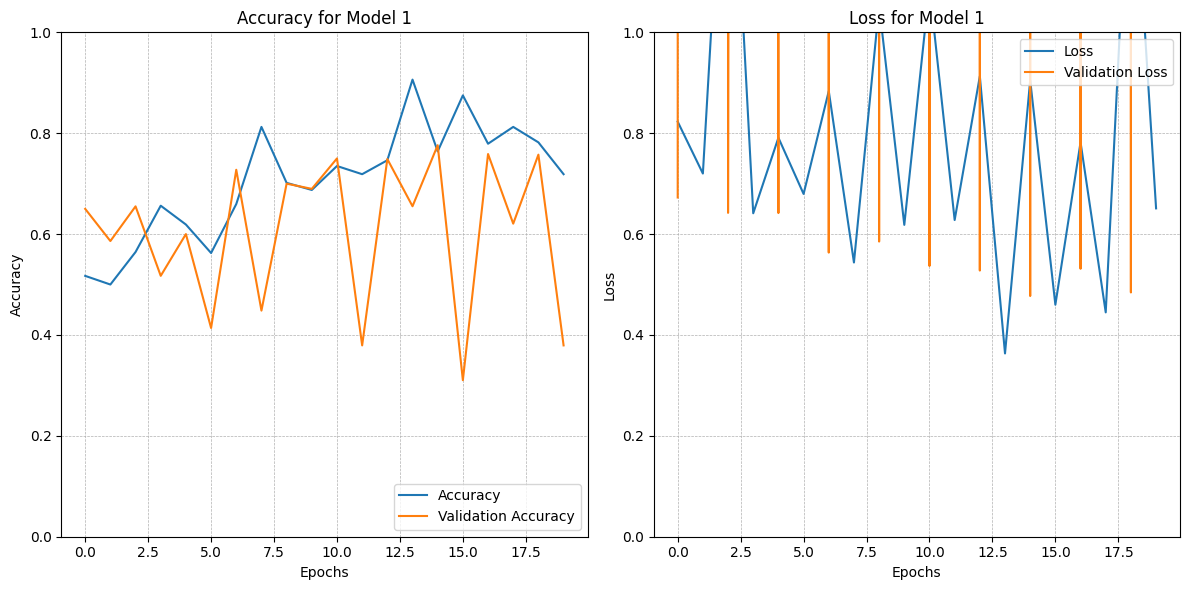

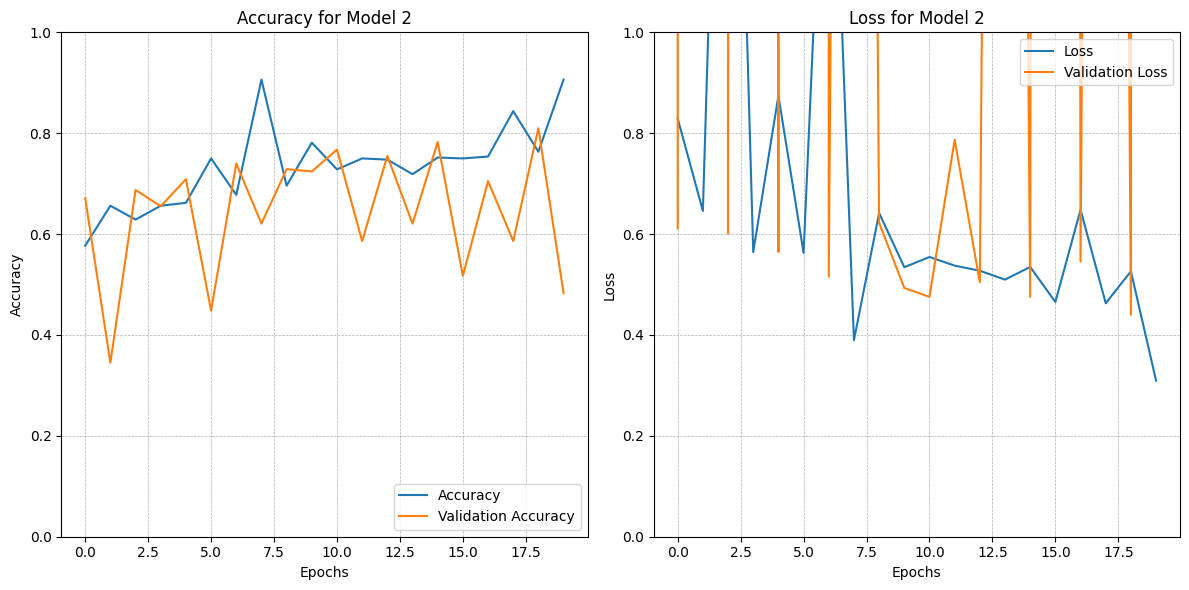

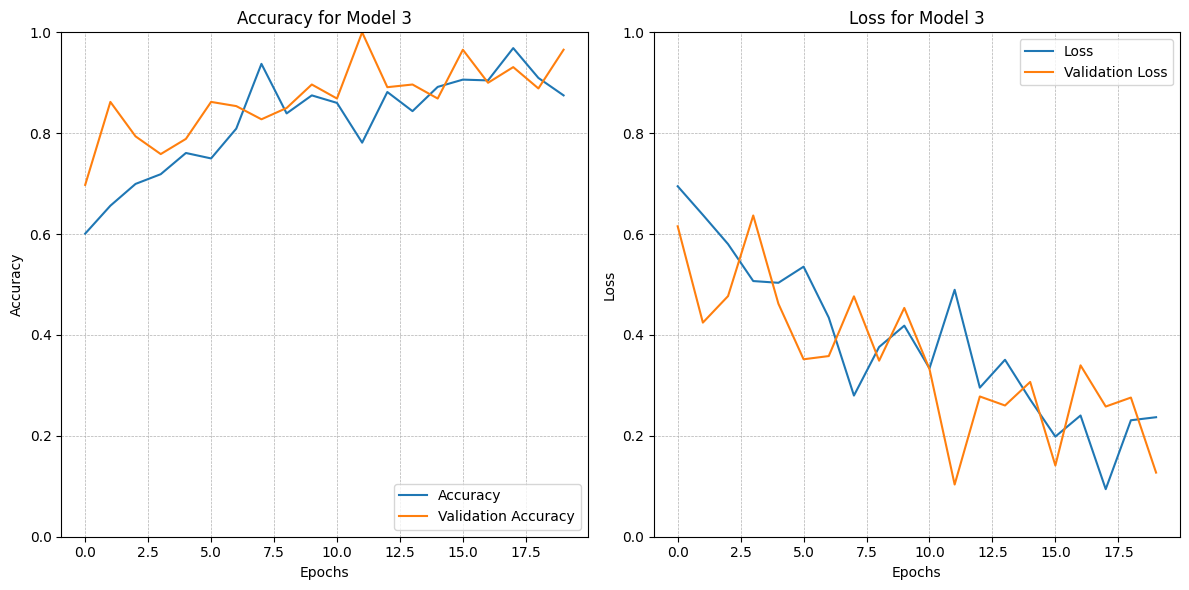

In [7]:
#  Model Results and Analysis

def plot_history(history, title_suffix=''):
    """
    Plots accuracy and loss graphs for the training and validation history.

    Parameters:
    - history: The history object from model.fit()
    - title_suffix: Optional string to append to the plot titles (useful for differentiating multiple plots)
    """
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f"Accuracy {title_suffix}")
    plt.legend(["Accuracy", "Validation Accuracy"], loc="lower right")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f"Loss {title_suffix}")
    plt.legend(["Loss", "Validation Loss"], loc="upper right")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Plots
plot_history(history1, title_suffix='for Model 1')
plot_history(history2, title_suffix='for Model 2')
plot_history(history3, title_suffix='for Model 3')


## Step 4: Results and analysis



Final Training Accuracy for Model 1: 0.7188
Final Validation Accuracy for Model 1: 0.3793
Final Training Accuracy for Model 2: 0.9062
Final Validation Accuracy for Model 2: 0.4828
Final Training Accuracy for Model 3: 0.8750
Final Validation Accuracy for Model 3: 0.9655


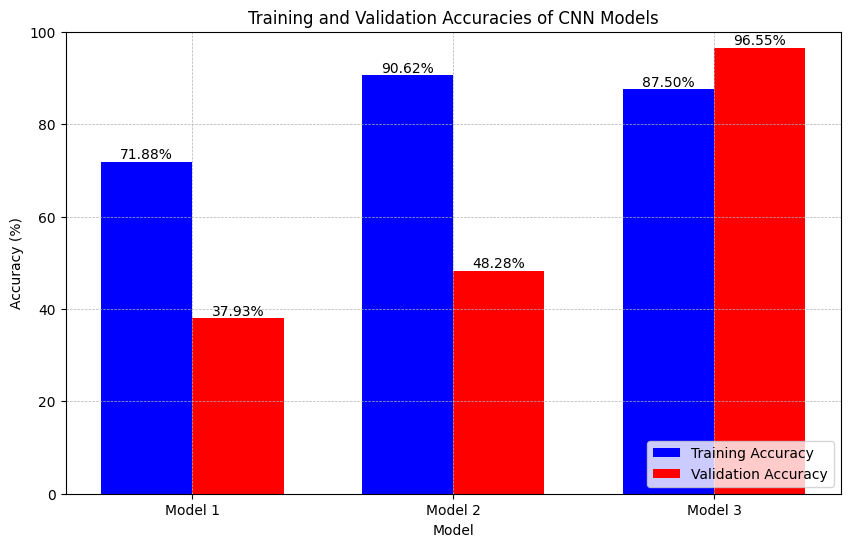

In [8]:
# Model performance results

# Print final values of accuracy and validation accuracy
final_accuracy1 = history1.history['accuracy'][-1]
final_val_accuracy1 = history1.history['val_accuracy'][-1]
print(f"Final Training Accuracy for Model 1: {final_accuracy1:.4f}")
print(f"Final Validation Accuracy for Model 1: {final_val_accuracy1:.4f}")

final_accuracy2 = history2.history['accuracy'][-1]
final_val_accuracy2 = history2.history['val_accuracy'][-1]
print(f"Final Training Accuracy for Model 2: {final_accuracy2:.4f}")
print(f"Final Validation Accuracy for Model 2: {final_val_accuracy2:.4f}")

final_accuracy3 = history3.history['accuracy'][-1]
final_val_accuracy3 = history3.history['val_accuracy'][-1]
print(f"Final Training Accuracy for Model 3: {final_accuracy3:.4f}")
print(f"Final Validation Accuracy for Model 3: {final_val_accuracy3:.4f}")


models = ['Model 1', 'Model 2', 'Model 3']

training_accuracies = [final_accuracy1*100, final_accuracy2*100, final_accuracy3*100]
validation_accuracies = [final_val_accuracy1*100, final_val_accuracy2*100, final_val_accuracy3*100]

# Create a bar width
bar_width = 0.35

# Set positions of the bars on the x-axis
index = np.arange(len(models))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training accuracies
train_bars = ax.bar(index, training_accuracies, bar_width, label='Training Accuracy', color='b')

# Plot validation accuracies
val_bars = ax.bar(index + bar_width, validation_accuracies, bar_width, label='Validation Accuracy', color='r')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Training and Validation Accuracies of CNN Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100%
ax.legend(loc='lower right')

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add text labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

add_labels(train_bars)
add_labels(val_bars)

# Display the plot
plt.show()

### Analysis 

The final results indicate significant differences in the performance and generalization of the three models. Model 1 achieved a final training accuracy of 0.7188 and a validation accuracy of 0.3793, indicating substantial overfitting. The loss function for Model 1 fluctuated wildly, with the validation loss showing extreme spikes, suggesting that the model struggled to generalize well to unseen data. Model 2 showed improvement, achieving a training accuracy of 0.9062 and a validation accuracy of 0.4828. However, similar issues with overfitting were observed, as evidenced by the erratic behavior of the validation loss during training. Despite these fluctuations, Model 2 managed to maintain relatively higher validation accuracy than Model 1.

Model 3 demonstrated the best performance with a training accuracy of 0.8750 and a validation accuracy of 0.9655, indicating a well-balanced model with less overfitting. The evolution of the loss functions for Model 3 was more consistent compared to the previous models, with both training and validation losses steadily decreasing. This consistency in the loss curves suggests that Model 3 was better able to learn from the training data and generalize to the validation set. The final results of Model 3 show a significant improvement in validation accuracy, making it the most effective model in this series of experiments. The model has less overfitting and superior generalization performance.

In [9]:
# Hyperparameter tuning
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy


def build_model(hp):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=128), (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
        loss=BinaryCrossentropy(),
        metrics=[Accuracy()]
    )
    return model


# Create a tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_tuning'
)

# Use the tuner to search for the best hyperparameters
tuner.search(train_generator, epochs=5, validation_data=val_generator)


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal hyperparameters
print(f"""
The optimal number of filters in the first conv layer is {best_hps.get('conv1_filters')}.
The optimal number of filters in the second conv layer is {best_hps.get('conv2_filters')}.
The optimal number of filters in the third conv layer is {best_hps.get('conv3_filters')}.
The optimal number of units in the dense layer is {best_hps.get('dense_units')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters
model = build_model(best_hps)

Trial 8 Complete [00h 00m 22s]

Best val_accuracy So Far: 0.0012062726309522986
Total elapsed time: 01h 01m 27s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
128               |128               |conv1_filters
64                |192               |conv2_filters
384               |128               |conv3_filters
640               |384               |dense_units
0.2               |0.4               |dropout
0.0006308         |0.0013415         |learning_rate



Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 155, in _build_hypermodel
    model

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 155, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_23/2598648745.py", line 24, in build_model
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'))
  File "/opt/conda/lib/python3.10/site-packages/keras/src/models/sequential.py", line 120, in add
    self._maybe_rebuild()
  File "/opt/conda/lib/python3.10/site-packages/keras/src/models/sequential.py", line 139, in _maybe_rebuild
    self.build(input_shape)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 223, in build_wrapper
    original_build_method(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/models/sequential.py", line 183, in build
    x = layer(x)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 5883, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access
tensorflow.python.framework.errors_impl.ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 



### Hyperparameter tuning Results


Despite the extensive range of hyperparameter variations, the process failed to achieve higher accuracy. This was most likely due to the lower number of epochs used (5 compared to 20 in the model before hyperparameter tuning). When we tried using a higher number of epochs, we consistently encountered runtime errors due to insufficient allocated memory. We initially started with 20 epochs and gradually decreased the number, but even with as few as 5 epochs, the runtime error persisted. This practical limitation prevented us from achieving better results, so we decided to stick with the results from model 3.

## Step 5: Conclusions

The results from the three models give us a good look at what worked and what didn’t. Model 1 clearly struggled with overfitting, showing big gaps between its training and validation accuracies and erratic validation loss. Model 2 did better, with higher accuracies overall, but it still had issues with overfitting and fluctuating validation loss. Model 3 was the standout, with much better balance and consistency in its loss functions, showing it could generalize well. Despite our efforts with hyperparameter tuning, we hit a wall with memory limits, which stopped us from running more epochs and getting the most out of our models. To improve, we need to boost our computational power availability to handle more extensive training and hyperparameter tweaking. Using more advanced optimization techniques, better regularization methods, and data augmentation can also help. By tackling these areas, we can push future models to be more accurate and reliable.